In [1]:
import rhythm_regression.audio_processing as ap
import rhythm_regression.midi_processing as mp

import librosa
import matplotlib.pyplot as plt
import mido
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

RANDOM_SEED = 9965 # The final score for the Blue Devils in 2014

# Loading Data

In [2]:
samples_table = pd.read_csv('./data/Samples.csv', index_col=0)
samples_table.drop(index=[16], inplace=True) # Sample 16 has a player mistake causing two missing notes
samples_table.head(20)

,midi_file,tempo,dynamic,composer,recorded with,distance to mic (ft),Room,audible met,met type,extra transients,missing notes
sample_id,,,,,,,,,,,
1,Ram_8's_120bpm.mid,120,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,NaN
2,Ram_8's_120bpm.mid,120,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,NaN
3,Ram_8's_120bpm.mid,120,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,NaN
4,Ram_8's_120bpm.mid,120,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,NaN,NaN
5,Ram_8's_120bpm.mid,120,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,NaN,NaN
6,Ram_8's_135bpm.mid,135,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,NaN,NaN
7,Ram_8's_135bpm.mid,135,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,NaN,NaN
8,Ram_8's_135bpm.mid,135,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,NaN
9,Ram_8's_135bpm.mid,135,F,Christian Kuhlman,iphone,5,bedroom,False,metropitch,True,NaN


In [3]:
midi_objects = {file: mido.MidiFile(f'./data/midi/{file}') for file in samples_table['midi_file'].unique()}
midi_vectors = {file: mp.get_midi_vector(midi_objects[file]) for file in midi_objects.keys()}
midi_vectors.keys()

dict_keys(["Ram_8's_120bpm.mid", "Ram_8's_135bpm.mid", "Ram_8's_168bpm.mid", 'Accent_Trap_(Edited)_110bpm.mid', 'Accent_Trap_(Edited)_120bpm.mid', 'Accent_Trap_(Edited)_130bpm.mid', 'Accent_Trap_(Edited)_140bpm.mid', '1eAnd_Accent_Grid_100bpm.mid', '1eAnd_Accent_Grid_110bpm.mid', '1eAnd_Accent_Grid_120bpm.mid', '1eAnd_Accent_Grid_130bpm.mid', 'CAM_Rolls_(Edited)_120bpm.mid', 'CAM_Rolls_(Edited)_130bpm.mid', 'CAM_Rolls_(Edited)_140bpm.mid', 'CSU_Double_Triple_Beat_100bpm.mid', 'CSU_Double_Triple_Beat_110bpm.mid', 'CSU_Double_Triple_Beat_120bpm.mid', 'CSU_Green_Beat_(Top_to_17)_110bpm.mid', 'CSU_Green_Beat_(17_to_End)_110bpm.mid', 'CSU_Fight_Song_138bpm.mid'])

In [4]:
num_notes = []

for sample_id, row in samples_table.iterrows():
    midi_file = row['midi_file']
    vector = midi_vectors[midi_file]
    num_notes.append(len(vector))

num_notes

[97,
 97,
 97,
 97,
 97,
 97,
 97,
 97,
 97,
 97,
 97,
 97,
 97,
 97,
 97,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 137,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 145,
 291,
 291,
 291,
 291,
 291,
 291,
 291,
 291,
 291,
 291,
 291,
 291,
 291,
 291,
 291,
 201,
 201,
 201,
 201,
 201,
 201,
 201,
 201,
 201,
 201,
 201,
 201,
 201,
 201,
 201,
 228,
 228,
 228,
 228,
 228,
 189,
 189,
 189,
 189,
 189,
 510,
 510,
 510,
 510,
 510]

In [5]:
samples = np.array([librosa.load(f'./data/audio/Sample {sample_id}.m4a')[0] for sample_id in tqdm(samples_table.index)])
print([audio.shape for audio in samples])

100%|██████████| 99/99 [02:29<00:00,  1.51s/it]

[(663735,), (671732,), (670320,), (655738,), (667028,), (595056,), (585178,), (598820,), (587530,), (609168,), (531552,), (529671,), (496743,), (502388,), (510855,), (919632,), (916810,), (903168,), (955383,), (851424,), (847661,), (847191,), (868829,), (844839,), (786039,), (801092,), (830727,), (798269,), (794506,), (754992,), (733824,), (753581,), (740880,), (736176,), (814263,), (777572,), (807207,), (786980,), (773338,), (744173,), (707952,), (735236,), (720183,), (728180,), (665616,), (653856,), (629396,), (644448,), (677847,), (603994,), (604464,), (601642,), (609168,), (632218,), (1073453,), (999600,), (1009949,), (982196,), (1033940,), (924807,), (906932,), (943152,), (918221,), (935626,), (888586,), (861773,), (883412,), (912576,), (894231,), (1091328,), (1072983,), (1085213,), (1097914,), (1056989,), (952560,), (994896,), (1006186,), (1003834,), (984548,), (881530,), (897994,), (892820,), (925277,), (897053,), (890468,), (793095,), (765341,), (761108,), (768634,), (1010890,)

# Parameter Grid Search with Scikit-learn

In [9]:
class NumTransientEstimator(BaseEstimator):

    def __init__(self, frame_size, hop_length, amplitude_threshold, verbose=False):
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.amplitude_threshold = amplitude_threshold
        self.verbose = verbose

    def fit(self, X, y):
        pass

    def predict(self, X):

        iterator = tqdm(X) if self.verbose else X
        return np.array([len(ap.transients(audio, 
                            frame_size=self.frame_size, hop_length=self.hop_length, amplitude_threshold=self.amplitude_threshold))
                        for audio in iterator])

In [10]:
nte = NumTransientEstimator(600,300,0.02)

In [11]:
nte.predict(samples)

array([100,  98,  98,  97,  98,  97, 117, 101, 100, 125, 100, 101, 101,
       101, 103, 136, 137, 137, 136, 136, 137, 137, 139, 140, 136, 139,
       137, 140, 136, 137, 137, 137, 137, 137, 146, 145, 145, 146, 145,
       145, 146, 145, 146, 145, 145, 145, 146, 145, 145, 145, 146, 145,
       145, 145, 291, 291, 293, 292, 292, 290, 292, 291, 291, 290, 290,
       291, 291, 289, 290, 205, 200, 201, 201, 201, 201, 201, 202, 202,
       203, 203, 201, 202, 202, 202, 233, 240, 239, 231, 233, 192, 202,
       190, 200, 196, 511, 515, 510, 512, 514])

In [12]:
params = {'frame_size': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
          'hop_length': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600],
          'amplitude_threshold': [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]}

def total_absolute_error(y_true, y_pred):
    return np.absolute(y_true - y_pred).sum()

ta_errors = []
grid = ParameterGrid(params)
for p in tqdm(grid):
    nte.set_params(**p)
    y_pred = nte.predict(samples)
    ta_errors.append(total_absolute_error(num_notes, y_pred))

results = pd.DataFrame({'amplitude_threshold': [p['amplitude_threshold'] for p in grid], 
                        'hop_length': [p['hop_length'] for p in grid],
                        'frame_size': [p['frame_size'] for p in grid],
                        'total_absolute_error': ta_errors})

results.sort_values(by='total_absolute_error', inplace=True)
results.head(20)

100%|██████████| 1200/1200 [21:25<00:00,  1.07s/it]


,amplitude_threshold,hop_length,frame_size,total_absolute_error
438,0.020,350,700,58
448,0.020,250,800,61
439,0.020,400,700,63
449,0.020,300,800,63
428,0.020,450,600,66
437,0.020,300,700,72
440,0.020,450,700,73
427,0.020,400,600,73
451,0.020,400,800,78
450,0.020,350,800,79


(0.0, 300.0)

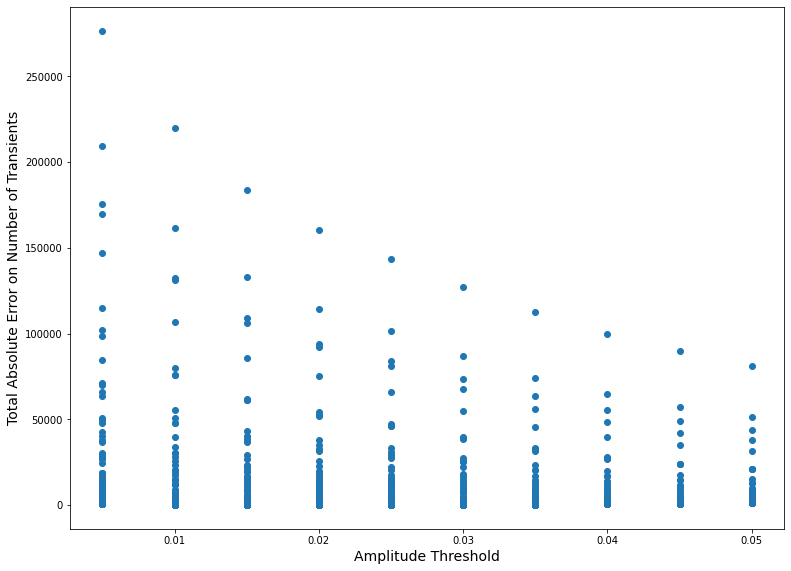

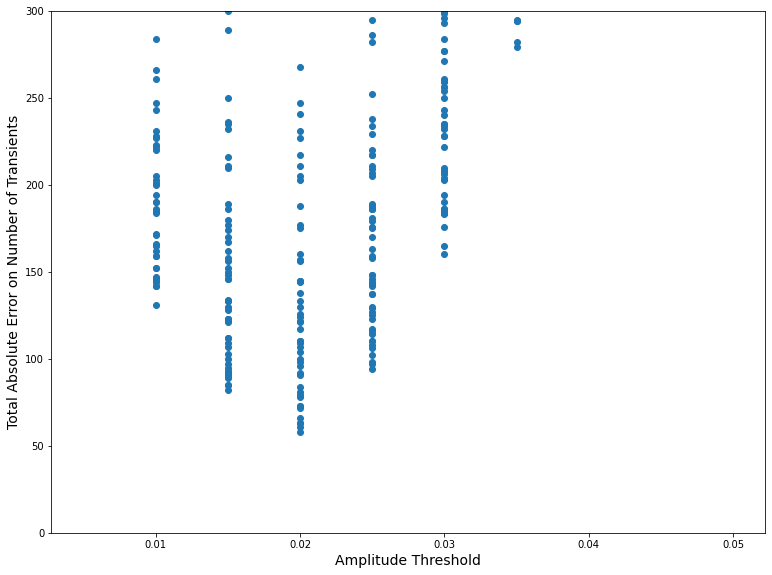

In [13]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(results['amplitude_threshold'], results['total_absolute_error'])
plt.xlabel('Amplitude Threshold', fontsize=14)
plt.ylabel('Total Absolute Error on Number of Transients', fontsize=14)

plt.figure(figsize=(12.8, 9.6))
plt.scatter(results['amplitude_threshold'], results['total_absolute_error'])
plt.xlabel('Amplitude Threshold', fontsize=14)
plt.ylabel('Total Absolute Error on Number of Transients', fontsize=14)
plt.ylim([0,300])

(0.0, 300.0)

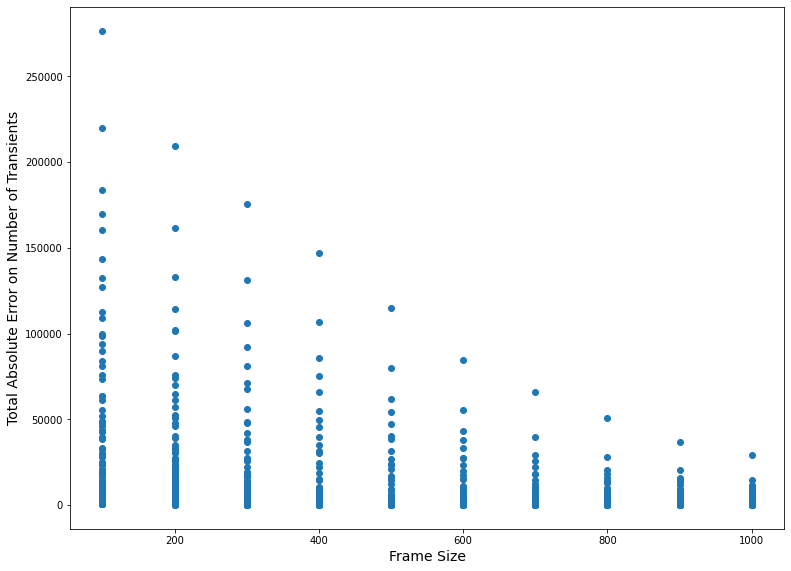

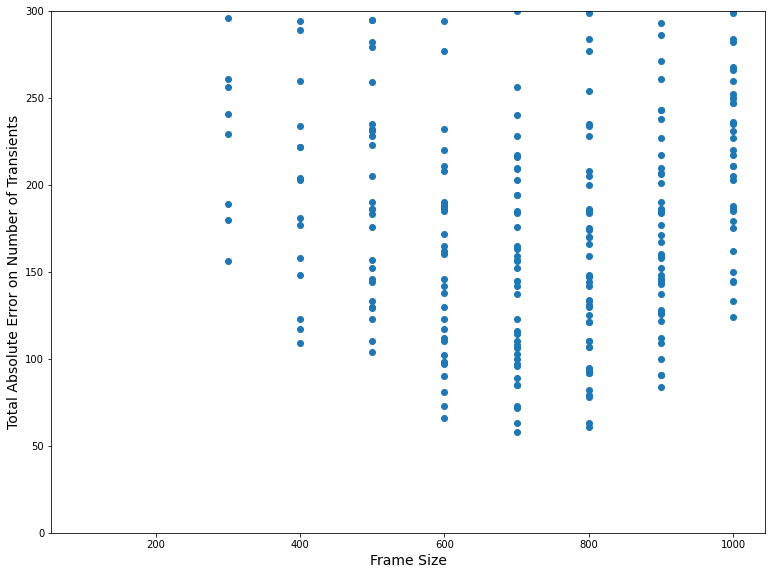

In [14]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(results['frame_size'], results['total_absolute_error'])
plt.xlabel('Frame Size', fontsize=14)
plt.ylabel('Total Absolute Error on Number of Transients', fontsize=14)

plt.figure(figsize=(12.8, 9.6))
plt.scatter(results['frame_size'], results['total_absolute_error'])
plt.xlabel('Frame Size', fontsize=14)
plt.ylabel('Total Absolute Error on Number of Transients', fontsize=14)
plt.ylim([0,300])

(0.0, 300.0)

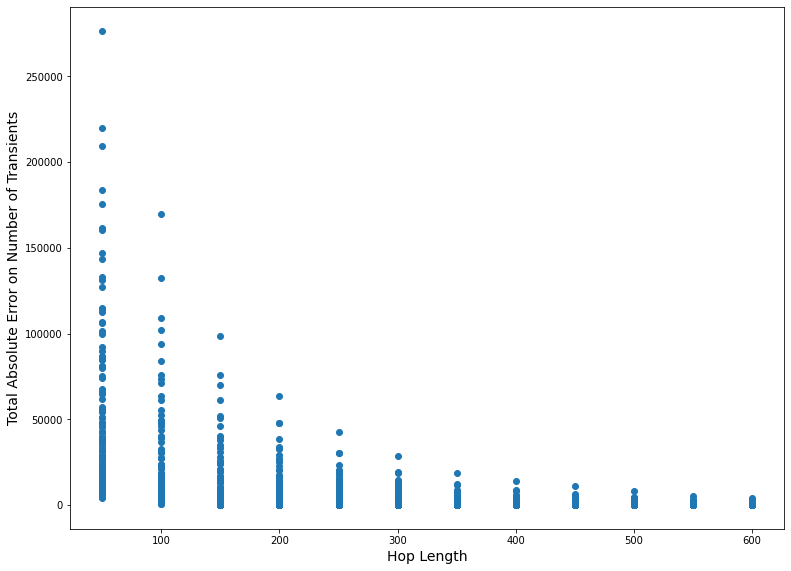

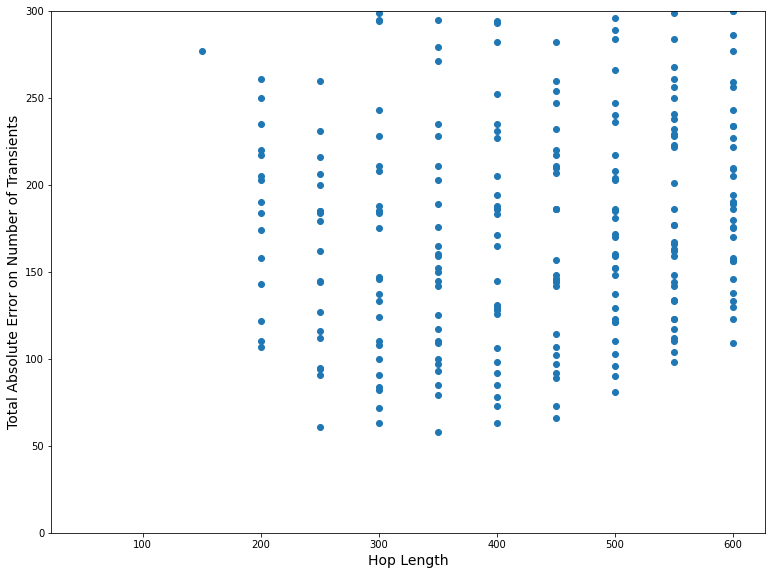

In [15]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(results['hop_length'], results['total_absolute_error'])
plt.xlabel('Hop Length', fontsize=14)
plt.ylabel('Total Absolute Error on Number of Transients', fontsize=14)

plt.figure(figsize=(12.8, 9.6))
plt.scatter(results['hop_length'], results['total_absolute_error'])
plt.xlabel('Hop Length', fontsize=14)
plt.ylabel('Total Absolute Error on Number of Transients', fontsize=14)
plt.ylim([0,300])

# Results

In [16]:
nte.set_params(**{'amplitude_threshold': results['amplitude_threshold'].iloc[0], 
                'frame_size': int(results['frame_size'].iloc[0]),
                'hop_length': int(results['hop_length'].iloc[0])})
y_pred = nte.predict(samples)

num_transients_table = pd.DataFrame({'midi_file': samples_table['midi_file'], 
                                    'detected_transients': y_pred, 'midi_notes': num_notes})
num_transients_table['num_transient_error'] = num_transients_table['detected_transients'] - num_transients_table['midi_notes']
num_transients_table

,midi_file,detected_transients,midi_notes,num_transient_error
sample_id,,,,
1,Ram_8's_120bpm.mid,98,97,1
2,Ram_8's_120bpm.mid,98,97,1
3,Ram_8's_120bpm.mid,98,97,1
4,Ram_8's_120bpm.mid,97,97,0
5,Ram_8's_120bpm.mid,97,97,0
6,Ram_8's_135bpm.mid,97,97,0
7,Ram_8's_135bpm.mid,97,97,0
8,Ram_8's_135bpm.mid,98,97,1
9,Ram_8's_135bpm.mid,99,97,2


In [17]:
num_transients_table['num_transient_error'].abs().sum()

58

In [18]:
num_transients_table['num_transient_error'].describe()

count    99.000000
mean     -0.060606
std       0.998143
min      -5.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000
Name: num_transient_error, dtype: float64

In [19]:
num_transients_table[num_transients_table['num_transient_error'] == 0 ].count()

midi_file              53
detected_transients    53
midi_notes             53
num_transient_error    53
dtype: int64

Only about half of the files have the corrent number of transients detected.